In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

2023-08-03 11:22:56.223263: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-03 11:22:56.276009: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-03 11:22:57.398468: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-03 11:22:58.415257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at http

In [2]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("/var/basefolder_smit/largelm/localdata/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [3]:
candidate_sentences['sentence'].sample(5)

292     original ones included across the universe , moulin rouge! , idlewild  and yesterday .
443                       karma  is a 2015 thai horror-drama film directed by kanittha kwanyu.
1807                         it was only involved in approximately 20 french film productions.
2016                                           the plot revolves around thulasi  and krishna .
3148                                                         the film earned critical acclaim.
Name: sentence, dtype: object

In [4]:

def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [5]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [6]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:28<00:00, 153.88it/s]


In [7]:
entity_pairs[10:20]


[['we', 'tests'],
 ['m', 'international sales rights'],
 ['canadian musician robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['military  forces', 'arrest'],
 ['train', 'vuk'],
 ['kota eberhardt', 'telepath selene gallio'],
 ['singer', 'men']]

In [8]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern], on_match = None)  

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [9]:
get_relation("John completed the task")

'completed'

In [10]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]


100%|██████████| 4318/4318 [00:28<00:00, 152.00it/s]


In [11]:
pd.Series(relations).value_counts()[:50]


is               364
was              308
released on       90
are               74
include           73
were              68
released          41
's                39
composed by       34
became            31
have              31
has               30
become            28
released in       27
included          23
had               21
produced          21
been              20
called            19
used              19
considered        18
made              18
scheduled         17
be                17
directed by       16
stars             16
hired             14
produced by       14
written by        13
wrote             13
received          13
introduced in     13
went              13
wanted            12
sold              12
began in          11
set               11
began             11
cast as           11
won               11
gave              10
directed          10
includes          10
gives              9
going              9
produced in        9
opened             9
features     

In [12]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [13]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

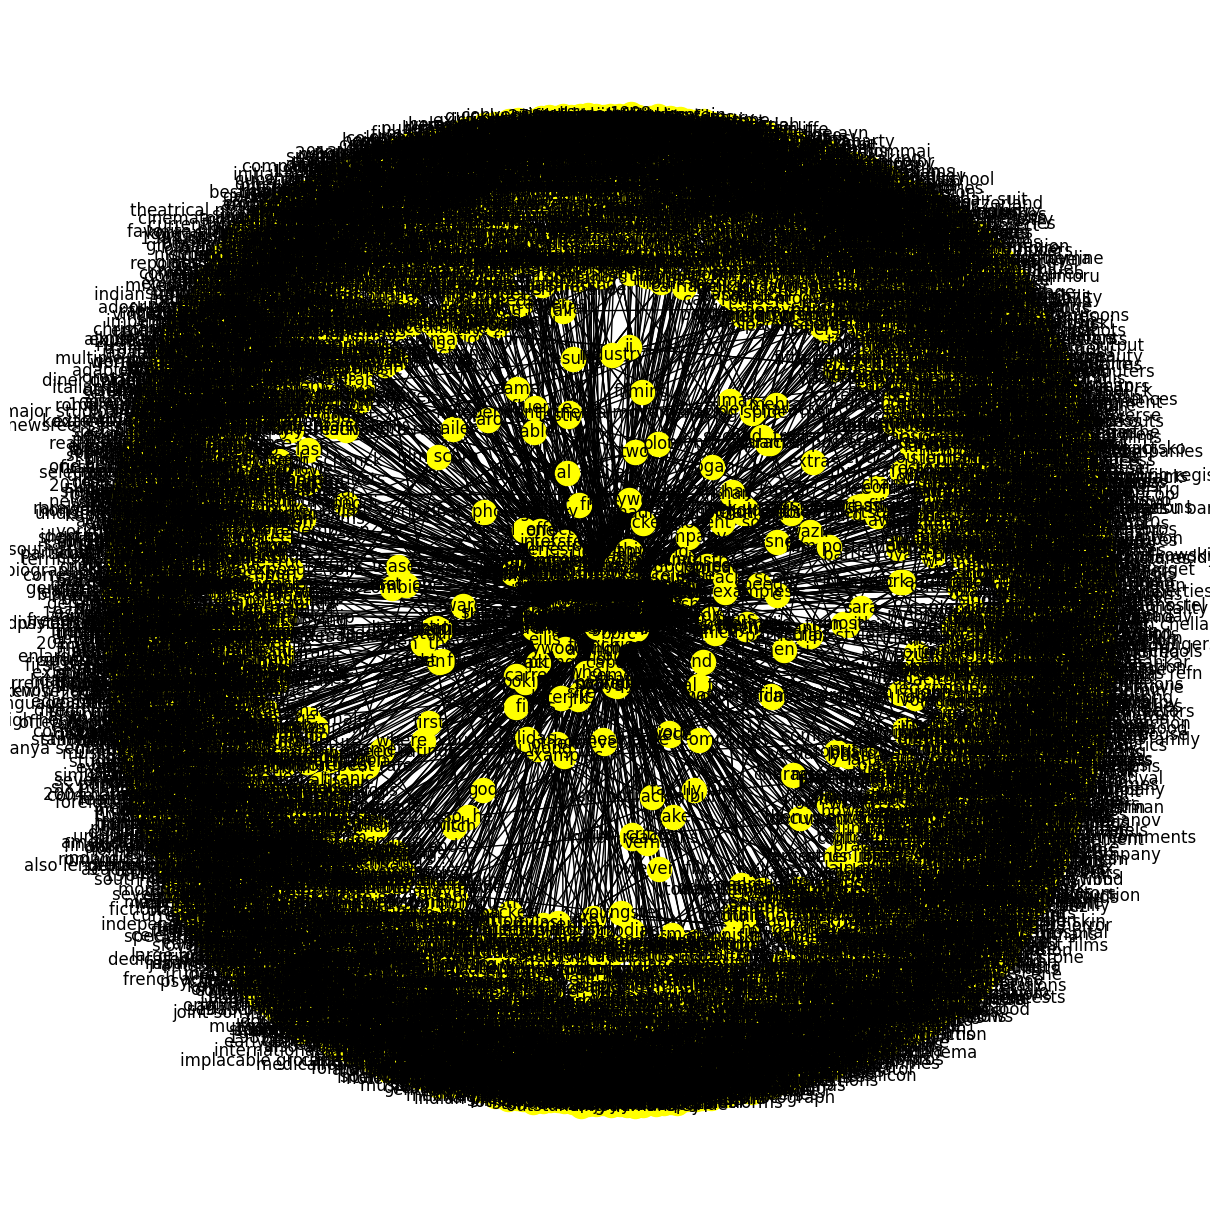

In [14]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='yellow', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

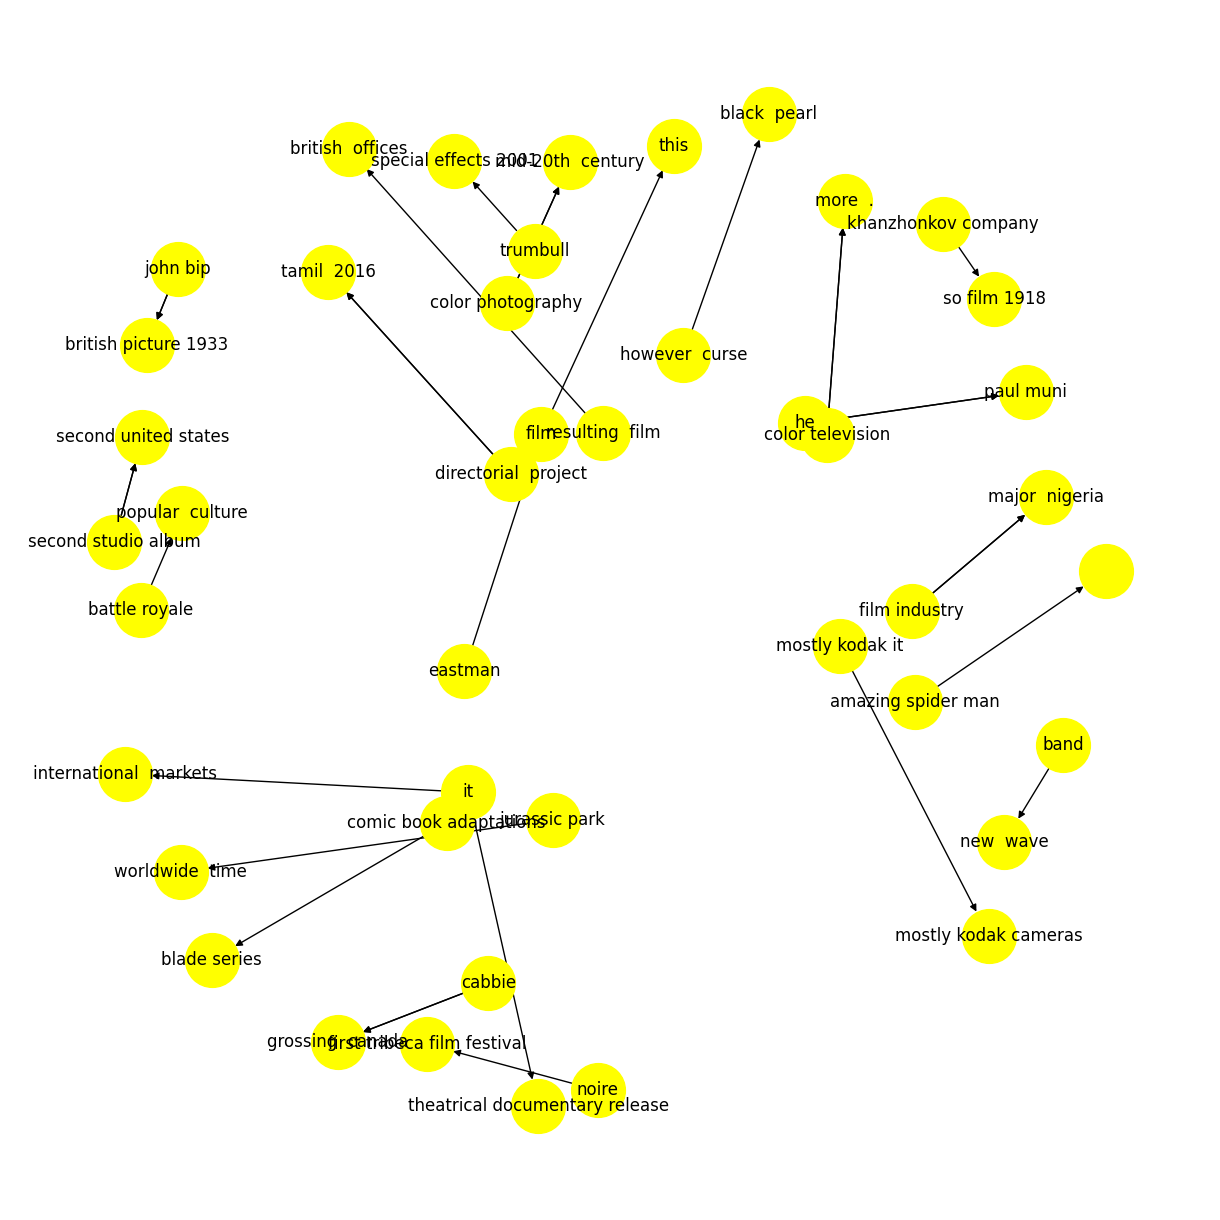

In [15]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="became"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='yellow', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [16]:
# Import Libraries

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
kg_df

,source,target,edge
0,connie,own,decides
1,later scream,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,,outside cult him,wails with
...,...,...,...
4313,confidencial,negatively film,responded
4314,le parisien,five star rating,gave
4315,museum collection,"37,000 film titles",includes
4316,predecessor,historical film 1946,was


In [18]:
f = open("myfile.txt", "w+")

In [19]:
for i in candidate_sentences['sentence']:
    print(i)

confused and frustrated, connie decides to leave on her own.
later, a woman’s scream is heard in the distance.
christian is then paralyzed by an elder.
the temple is set on fire.
outside, the cult wails with him.
it's a parable of a woman's religious awakening—
c. mackenzie, and craig vincent joined the cast.
later, craig di francia and action bronson were revealed to have joined the cast.
sebastian maniscalco and paul ben-victor were later revealed as being part of the cast.
we just tried to make the film.
we went through all these tests and things  
m global was also circling to bid for the film's international sales rights.
canadian musician robbie robertson supervised the soundtrack.
it features both original and existing music tracks.
it is the worst reviewed film in the franchise.
but she injures quicksilver and accidentally kills mystique before flying away.
military forces tasked with her arrest.
the train is attacked by vuk and her d'bari forces.
kota eberhardt portrays telepa

In [20]:
f.writelines(candidate_sentences['sentence'])

In [21]:
newdb = pd.read_csv("/var/basefolder_smit/largelm/knowledge-graph/data/output/kg/input_data.txt-out.csv")

In [22]:
newdb

,Godfather,directed by,Coppola
0,Godfather,is,1972 American crime film
1,Godfather,is,1972 crime film
2,Mario Puzo,on,best-selling novel of same name
3,Godfather,is,American
4,It,stars,Marlon Brando
5,It,stars Marlon Brando as,leaders of fictional New York crime family
6,It,stars Marlon Brando as,leaders
7,story,chronicles family under,patriarch Vito Corleone
8,story,chronicles family under,patriarch Vito Corleone focusing on transformation of Michael Corleone from reluctant family outsider to mafia boss
9,story,chronicles family under,patriarch Vito Corleone focusing on transformation from family outsider
